<a href="https://colab.research.google.com/github/MizDaWiz/Basic-DL-Projects/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Imports

In [ ]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda'

batch_size = 128 
noise_dim = 64

#optimizer parameters

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#Training Variables

epochs = 20

# Loading MNIST Dataset 

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
                        T.RandomRotation((-20,20)),
                        T.ToTensor()
])

In [ ]:
trainset=datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 417029051.05it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 113422934.29it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 167710827.57it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22049223.11it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Number of Training Images: 60000


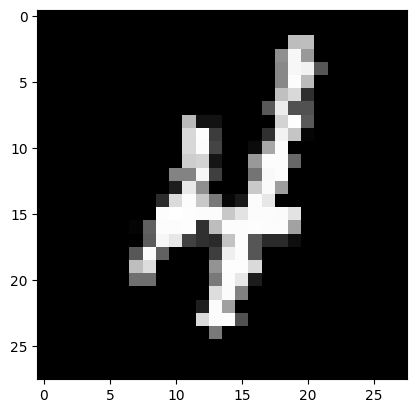

In [ ]:
image, label = trainset[9]

plt.imshow(image.squeeze(), cmap = 'gray')

print("Number of Training Images:", len(trainset))

# Loading Dataset Into Batches 

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print("No of batches:", len(trainloader))

No of batches: 469


In [ ]:
dataiter= iter(trainloader)
images, __ = next(dataiter)
print(images.shape)
print(__)

torch.Size([128, 1, 28, 28])
tensor([7, 1, 8, 8, 6, 1, 1, 5, 3, 8, 8, 4, 2, 0, 0, 0, 0, 2, 3, 7, 8, 3, 3, 8,
        9, 5, 1, 5, 7, 4, 7, 1, 9, 2, 3, 5, 5, 2, 2, 0, 0, 1, 1, 6, 7, 4, 9, 4,
        6, 4, 9, 8, 3, 1, 3, 6, 9, 3, 6, 3, 5, 8, 9, 5, 4, 3, 9, 2, 5, 0, 8, 3,
        4, 2, 1, 2, 9, 3, 1, 8, 1, 8, 6, 6, 1, 6, 7, 6, 7, 3, 0, 2, 5, 9, 5, 5,
        8, 8, 2, 4, 7, 9, 2, 0, 4, 6, 9, 2, 3, 9, 0, 0, 3, 2, 3, 3, 5, 1, 2, 9,
        9, 2, 5, 6, 6, 1, 3, 5])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

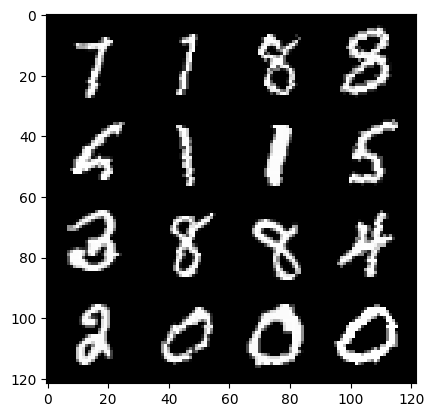

In [ ]:
show_tensor_images(images, num_images = 16)

#Discriminator Network 

In [ ]:
from torch import nn 
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return(
      nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride),
                    nn.BatchNorm2d(out_channels),
                    nn.LeakyReLU(0.2)
      )
  )

In [ ]:
class Discriminator(nn.Module): 
  def __init__(self):
    super(Discriminator, self).__init__()
    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear= nn.Linear(in_features = 64, out_features = 1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4= self.flatten(x3)
    y = self.linear(x4)

    return y 


In [ ]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

#Generator Network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, Final_Block=False):
  if Final_Block:
    return(
        nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    )
  return(
      nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )
  )

In [ ]:
class Generator(nn.Module): 
  def __init__(self, noise_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim

    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, Final_Block = True)

  def forward(self, noise_vec):

    x = noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    y= self.block_4(x3)
  
    return y

In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_Loss: 0.6857726483711047 | G_Loss: 0.6891847819661789


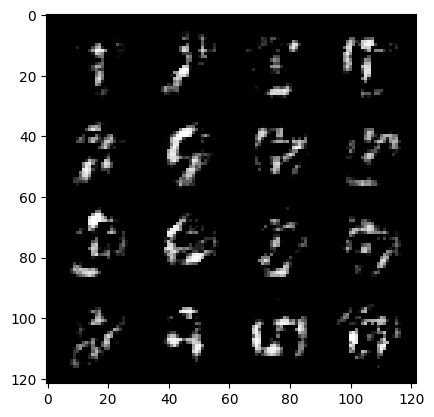

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_Loss: 0.679762300143618 | G_Loss: 0.7101443148116822


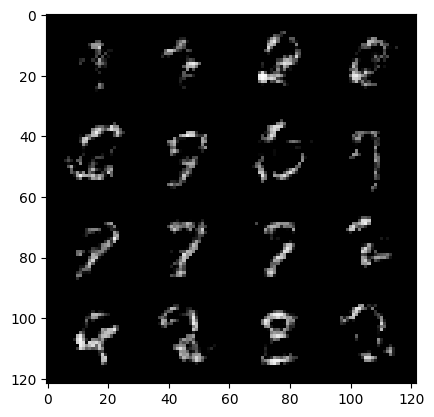

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_Loss: 0.6469126653823771 | G_Loss: 0.7486183202342946


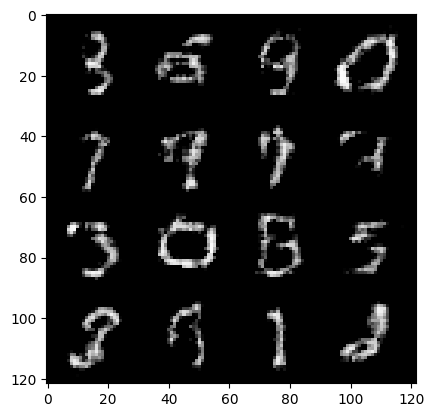

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_Loss: 0.609126969949523 | G_Loss: 0.7977496699483664


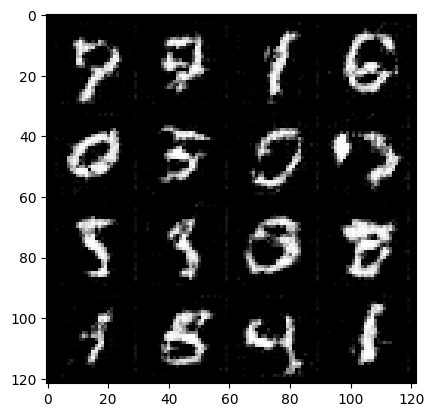

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_Loss: 0.597070604499215 | G_Loss: 0.8230712803950442


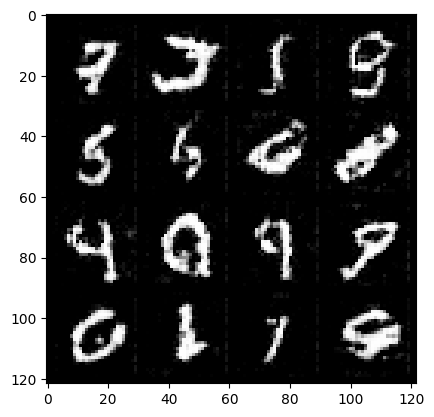

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_Loss: 0.5945621376861133 | G_Loss: 0.8404434067862374


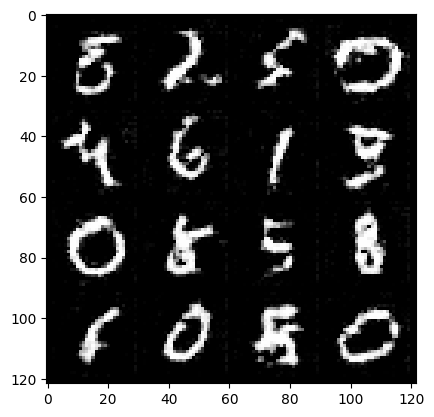

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_Loss: 0.5974071982827014 | G_Loss: 0.8468250066740934


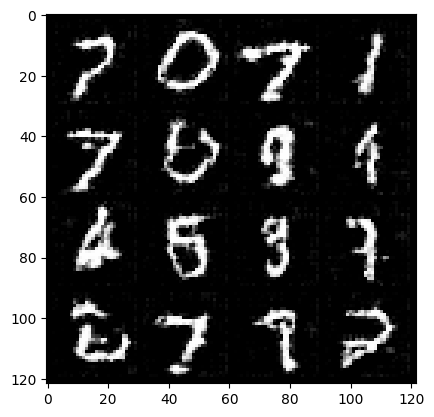

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_Loss: 0.6054313452259056 | G_Loss: 0.8488499857723586


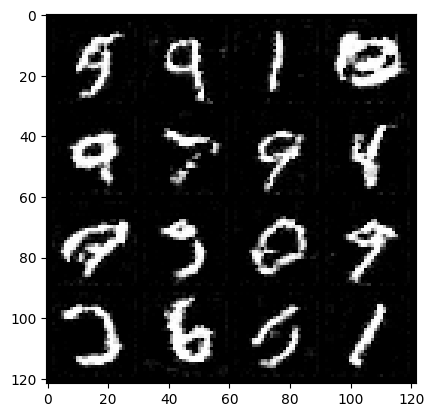

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_Loss: 0.6165487144801662 | G_Loss: 0.8405082347804803


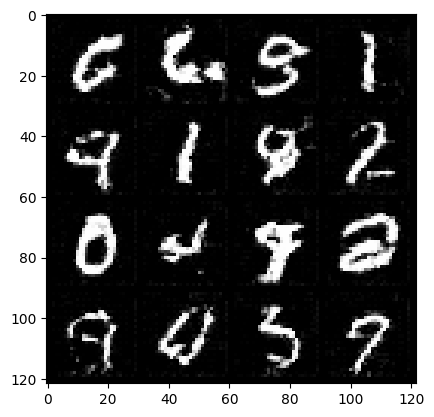

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_Loss: 0.6253123409204138 | G_Loss: 0.8317263763088153


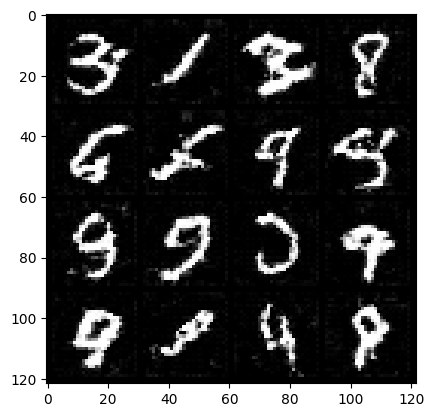

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_Loss: 0.63172440933012 | G_Loss: 0.8240356588922838


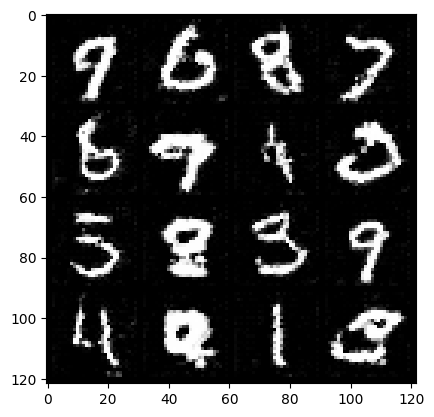

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_Loss: 0.636012458852105 | G_Loss: 0.8192744943887186


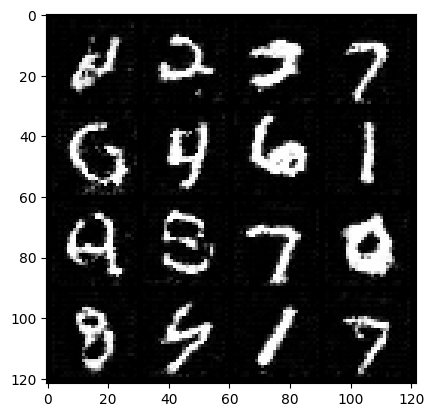

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_Loss: 0.6400291946396899 | G_Loss: 0.8131060633323849


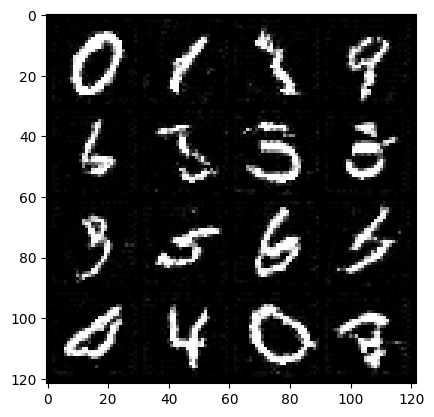

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_Loss: 0.6444626318366289 | G_Loss: 0.8048165535875983


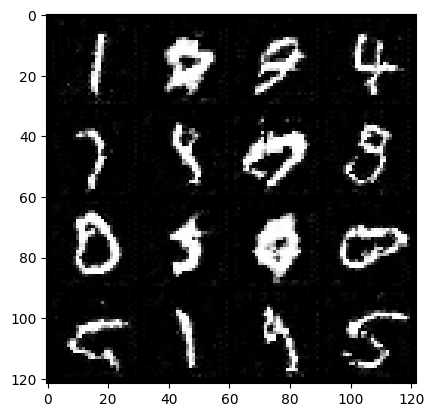

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_Loss: 0.6481879216267356 | G_Loss: 0.800754959395191


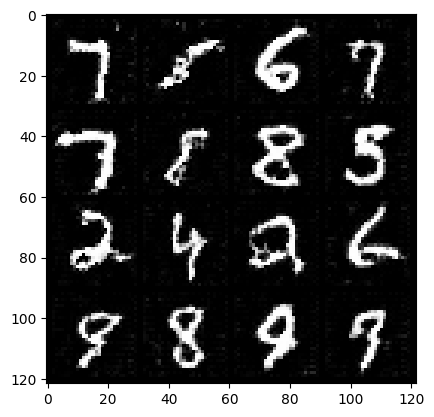

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_Loss: 0.6485524613465836 | G_Loss: 0.7976659776559517


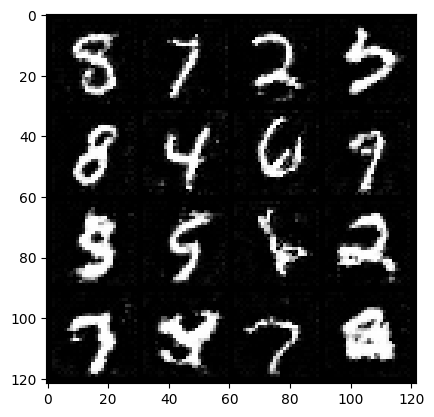

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_Loss: 0.6506083395435358 | G_Loss: 0.7972431740781137


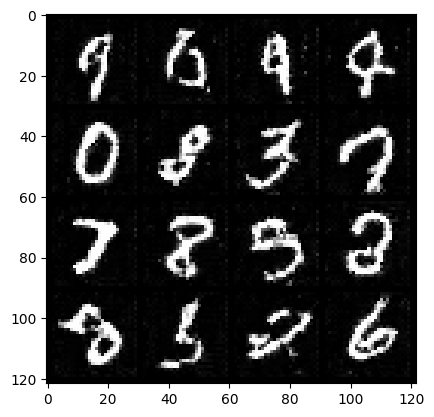

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_Loss: 0.6512477430961788 | G_Loss: 0.79642734980024


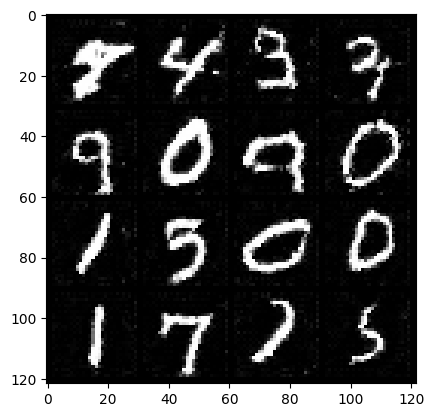

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_Loss: 0.6524031345269827 | G_Loss: 0.7931856581651325


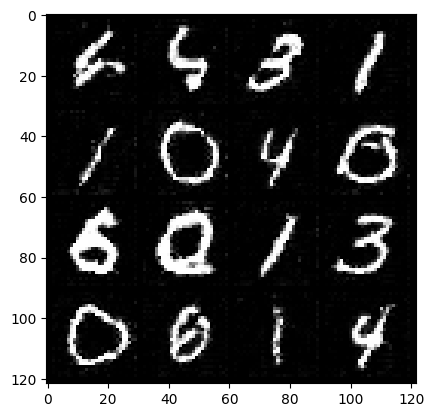

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_Loss: 0.6537884913527889 | G_Loss: 0.7910952815877349


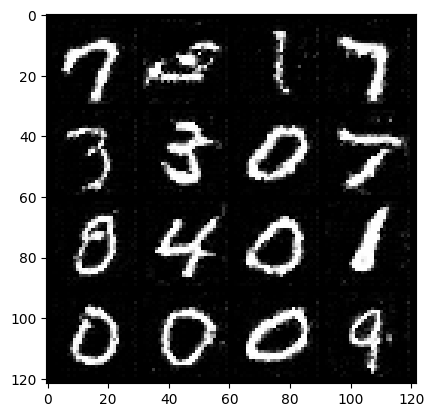

In [ ]:

for i in range(epochs):
  total_d_loss = 0.00
  total_g_loss = 0.00
  
  for real_img, _ in tqdm(trainloader):
        
        real_img= real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device = device)
        
        #Finding loss and updating weights for D

        D_opt.zero_grad()   

        fake_img = G(noise)     #generate fake image
        D_pred = D(fake_img)    #prediction of discriminator on fake image
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss)/2
        total_d_loss+= D_loss.item()

        D_loss.backward()
        D_opt.step()

        #Finding loss and updating weights for G

        G_opt.zero_grad()
        
        noise = torch.randn(batch_size, noise_dim, device = device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss+= G_loss.item()

        G_loss.backward()
        G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print("Epoch: {} | D_Loss: {} | G_Loss: {}".format(i+1, avg_d_loss, avg_g_loss))


  show_tensor_images(fake_img)

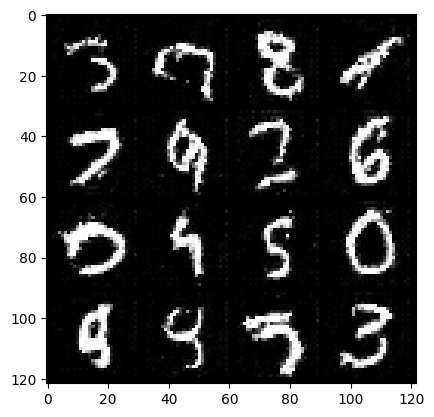

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)